In [ ]:
###### DON'T USE IT, CRASHES AFTER RUNNING FOR MORE THAN AN HOUR

# from datasets import load_dataset

# # Login using e.g. `huggingface-cli login` to access this dataset
# ds = load_dataset("AisotTechnologies/aisot_btc_lob_trades")

In [ ]:
###### USE THIS METHOD INSTEAD

# from huggingface_hub import snapshot_download

# snapshot_download(repo_id="AisotTechnologies/aisot_btc_lob_trades", allow_patterns="*.zip", local_dir='data/', repo_type='dataset')

Fetching 232 files: 100%|██████████| 232/232 [00:46<00:00,  4.97it/s]


'C:\\Users\\aliak\\my_space\\ETH\\ML Complex Systems\\MLFCS\\data'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
import os
from datasets import load_dataset

# Define the folder containing the ZIP files
data_folder = "./data/"

# Get all ZIP files containing "trx" in the filename
trx_zip_files = [
    os.path.join(data_folder, f) for f in os.listdir(data_folder) 
    if "trx" in f and f.endswith(".zip")
]

# Ensure that matching files were found
if not trx_zip_files:
    raise FileNotFoundError("No matching 'trx' ZIP files found in './data/'.")

# Load dataset using Hugging Face `load_dataset`
trx_dataset = load_dataset("csv", data_files=trx_zip_files)  # Adjust to "parquet" if needed



In [85]:
trx_dataset = trx_dataset['train'].to_pandas()
trx_dataset.rename({col:col.split("'")[1].strip() for col in trx_dataset.columns}, axis=1, inplace=True)
trx_dataset['datetime'] = pd.to_datetime(trx_dataset['datetime'])
trx_dataset.head()

,timestamp,price,datetime,cost,id,fee,fee1,order,symbol,amount,type,side
0,1527800413000,7538.34,2018-05-31 21:00:13+00:00,75.383400,67405327,{'currency': u'USD','cost': None},None,BTC/USD,0.010000,None,sell
1,1527800418000,7533.92,2018-05-31 21:00:18+00:00,35.761333,67405331,{'currency': u'USD','cost': None},None,BTC/USD,0.004747,None,sell
2,1527800418000,7535.44,2018-05-31 21:00:18+00:00,2995.337400,67405330,{'currency': u'USD','cost': None},None,BTC/USD,0.397500,None,sell
3,1527800418000,7536.00,2018-05-31 21:00:18+00:00,7.536000,67405329,{'currency': u'USD','cost': None},None,BTC/USD,0.001000,None,sell
4,1527800418000,7537.49,2018-05-31 21:00:18+00:00,753.749000,67405328,{'currency': u'USD','cost': None},None,BTC/USD,0.100000,None,sell


In [86]:
trx_dataset.dtypes

timestamp                  int64
price                    float64
datetime     datetime64[ns, UTC]
cost                     float64
id                         int64
fee                       object
fee1                      object
order                     object
symbol                    object
amount                   float64
type                      object
side                      object
dtype: object

### Preprocessing and Feature Creation

In [92]:
freq = '1min'
# Group by minute and transaction side
trx_dataset_grouped = trx_dataset.groupby([pd.Grouper(key='datetime', freq=freq, label='right', closed='left'), 'side']).agg(
    volume=('amount', 'sum'),  # Sum of volumes
    txn=('side', 'count')         # Count of transactions
).reset_index()

# Pivot to have separate columns for each transaction type
trx_dataset_grouped = trx_dataset_grouped.pivot(index='datetime', columns='side')

# Flatten multi-index columns
trx_dataset_grouped.columns = [f"{col}_{txn_side}" for txn_side, col in trx_dataset_grouped.columns]

# Reset index to make time a column again
trx_dataset_grouped = trx_dataset_grouped.reset_index()
# Fill missing values with 0
trx_dataset_grouped = trx_dataset_grouped.fillna(0)

# Create a complete range of minutes
full_range = pd.DataFrame({'datetime': pd.date_range(start=trx_dataset['datetime'].min().ceil('min'), 
                                                 end=trx_dataset['datetime'].max().ceil('min'), 
                                                 freq='min')})

# Merge with full time range to ensure all minutes are present
trx_dataset_grouped = full_range.merge(trx_dataset_grouped, on='datetime', how='left')

# Fill missing values with 0
trx_dataset_grouped = trx_dataset_grouped.fillna(0)

trx_dataset_grouped.rename({col:col.strip() for col in trx_dataset_grouped.columns}, axis=1, inplace=True)
trx_dataset_grouped['volume_imbalance'] = np.abs(trx_dataset_grouped["buy_volume"] - trx_dataset_grouped['sell_volume'])
trx_dataset_grouped['txn_imbalance'] = np.abs(trx_dataset_grouped['buy_txn'] - trx_dataset_grouped['sell_txn'])
trx_dataset_grouped['total_volume'] = trx_dataset_grouped["buy_volume"] + trx_dataset_grouped['sell_volume']

trx_dataset_grouped.head()


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume
0,2018-05-31 21:01:00+00:00,18.203291,0.677437,12.0,11.0,17.525854,1.0,18.880728
1,2018-05-31 21:02:00+00:00,0.218896,0.946981,5.0,6.0,0.728085,1.0,1.165876
2,2018-05-31 21:03:00+00:00,0.021258,0.011077,3.0,1.0,0.010181,2.0,0.032336
3,2018-05-31 21:04:00+00:00,0.143166,0.001062,8.0,1.0,0.142104,7.0,0.144229
4,2018-05-31 21:05:00+00:00,2.837166,0.000000,9.0,0.0,2.837166,9.0,2.837166


### Stackplot

In [108]:
trx_dataset_grouped['time'] = trx_dataset_grouped['datetime'].dt.time
trx_dataset_grouped_viz = trx_dataset_grouped.groupby("time")['total_volume'].quantile([0.25, 0.5, 0.75]).unstack()
trx_dataset_grouped_viz.rename({0.25:'Q1', 0.5:'Q2', 0.75:'Q3'}, axis=1, inplace=True)
trx_dataset_grouped_viz['Q1_Q2'] = trx_dataset_grouped_viz['Q2'] - trx_dataset_grouped_viz['Q1']  # Lower IQR (blue)
trx_dataset_grouped_viz['Q2_Q3'] = trx_dataset_grouped_viz['Q3'] - trx_dataset_grouped_viz['Q2']  # Upper IQR (green)
# Convert time index to minutes since midnight (numeric format for x-axis)
trx_dataset_grouped_viz['minutes_since_midnight'] = [t.hour * 60 + t.minute for t in trx_dataset_grouped_viz.index]

trx_dataset_grouped_viz.head()

,Q1,Q2,Q3,Q1_Q2,Q2_Q3,minutes_since_midnight
time,,,,,,
00:00:00,0.149442,1.182660,3.371082,1.033218,2.188422,0
00:01:00,0.375942,1.984938,7.351205,1.608996,5.366267,1
00:02:00,0.447086,2.585878,6.315642,2.138792,3.729764,2
00:03:00,0.304207,1.306180,6.271761,1.001973,4.965580,3
00:04:00,0.502046,2.120197,6.226218,1.618151,4.106022,4


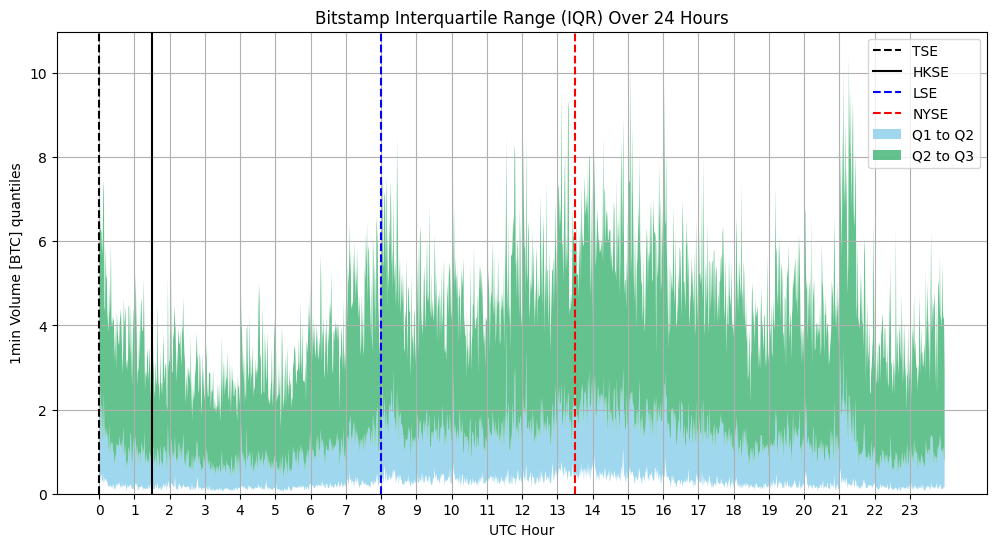

In [129]:
# Calculate IQR ranges


# Plot
fig, ax = plt.subplots(figsize=(12, 6))

minutes = [0, 90, 480, 810]  # Convert times to minutes since midnight

colors = ['black', 'black', 'blue', 'red']
labels = ['TSE', 'HKSE', 'LSE', 'NYSE']
for t, color, label in zip(minutes, colors, labels):
    if label == 'HKSE':
        ax.axvline(x=t, color=color, label=label)
    else:   
        ax.axvline(x=t, linestyle='--', color=color, label=label)

ax.stackplot(trx_dataset_grouped_viz['minutes_since_midnight'], trx_dataset_grouped_viz['Q1'], trx_dataset_grouped_viz['Q1_Q2'], trx_dataset_grouped_viz['Q2_Q3'], 
             labels=["", "Q1 to Q2", "Q2 to Q3"], colors=['none','skyblue', 'mediumseagreen'], edgecolor='none', alpha=0.8)

# Formatting X-axis to show only hours
ax.set_xticks(np.arange(0, 1381, 60))  # Tick every 60 minutes (every hour)
ax.set_xticklabels(range(0, 24))  # Labels from 0 to 23 (only hours)

# Labels and title
ax.set_xlabel("UTC Hour")
ax.set_ylabel("1min Volume [BTC] quantiles")
ax.set_title("Bitstamp Interquartile Range (IQR) Over 24 Hours")
ax.legend()
ax.grid(True)

plt.show()

### Distribution plot

In [137]:
trx_dataset_grouped['time'] = trx_dataset_grouped['datetime'].dt.time

trx_dataset_grouped['mean_volume'] = trx_dataset_grouped.groupby('time')['total_volume'].transform('mean')

trx_dataset_grouped['deseasoned_total_volume'] = trx_dataset_grouped['total_volume'] / trx_dataset_grouped['mean_volume']

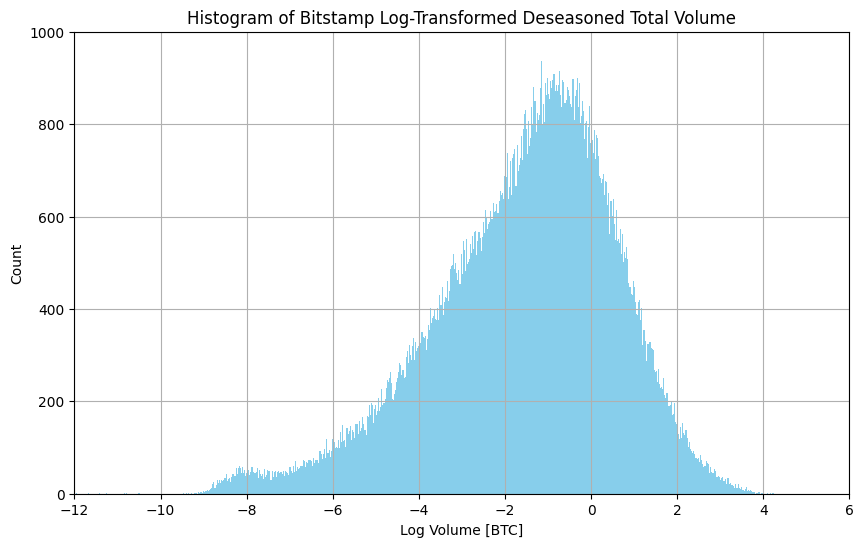

In [146]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(trx_dataset_grouped['deseasoned_total_volume']+1e-12), bins=1300, color='skyblue', edgecolor='none')
plt.xlim(-12,6)
plt.ylim(0,1000)
plt.title("Histogram of Bitstamp Log-Transformed Deseasoned Total Volume")
plt.xlabel("Log Volume [BTC]")
plt.ylabel("Count")
plt.grid(True)
plt.show()